In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from sklearn.metrics import f1_score
import graphviz
from sklearn import tree

### Загрузим данные

In [31]:
with open('kaggle.json', 'r') as kaggle:
    kaggle_info = json.load(kaggle)
    os.environ['KAGGLE_USERNAME'] = kaggle_info['username']
    os.environ['KAGGLE_KEY'] = kaggle_info['key']

!kaggle competitions download -c liverpool-ion-switching
!unzip -q train.csv.zip
!unzip -q test.csv.zip

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### Прероцессинг и первичный анализ данных

Из условия мы знаем, что данные представляют собой несколько временных рядов, где $i$-й ряд находится в промежутке $\left[50.0000 \cdot i + 0.0001, 50.0000 \cdot (i+1)\right]$.  
Т.е. каждому временному ряду соответствуют 500.000 строк.  
В `train` находится 10 временных рядов, в `test` 4 временных ряда.

In [32]:
train_data = pd.read_csv('train.csv')
print(len(train_data))
train_data.head(5)

5000000


,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


Посмотрим, какое максимальное количество открытых каналов возможно

In [33]:
print('Max open channels: {}'.format(np.max(train_data['open_channels'])))

Max open channels: 10


Таким образом, можно рассматривать задачу о классификации на 10 классов.  
Посмотрим, что из себя представляют временные ряды в `train`.  
Рассмотрим `signal`

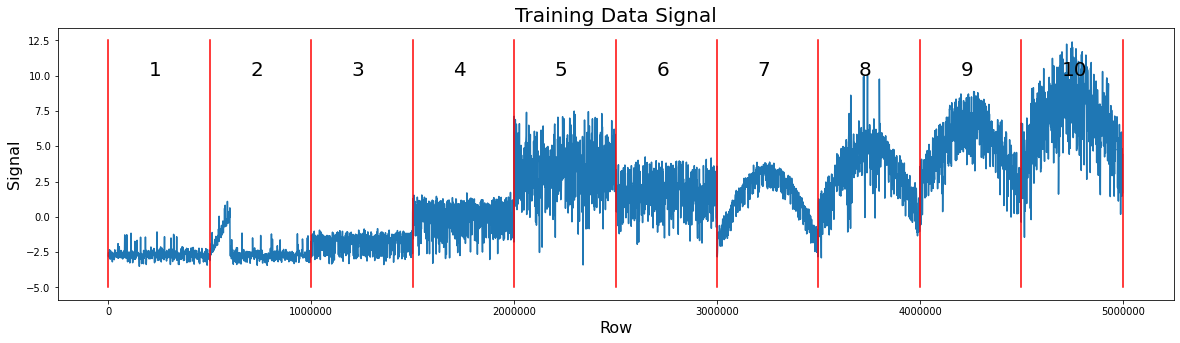

In [34]:
plt.figure(figsize=(20, 5))
res = 1000

# визуализируем каждый 500й сигнал
plt.plot(range(0, train_data.shape[0], res), train_data['signal'][0::res])

# построим разделяющие ряды прямые
for i in range(11):
    plt.plot([i * 500000,i * 500000], [-5, 12.5],'r')

# подпишем номер временного ряда
for j in range(10):
    plt.text(j*500000+200000, 10, str(j+1), size=20)

plt.xlabel('Row',size=16)
plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal',size=20)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000, 5000000],
           ['0', '1000000', '2000000', '3000000', '4000000', '5000000'])
plt.show()

Видно, что временные ряды отличаются друг от друга на графиках, имеют "разную" форму и разброс.  
Рассмотрим `open channels`

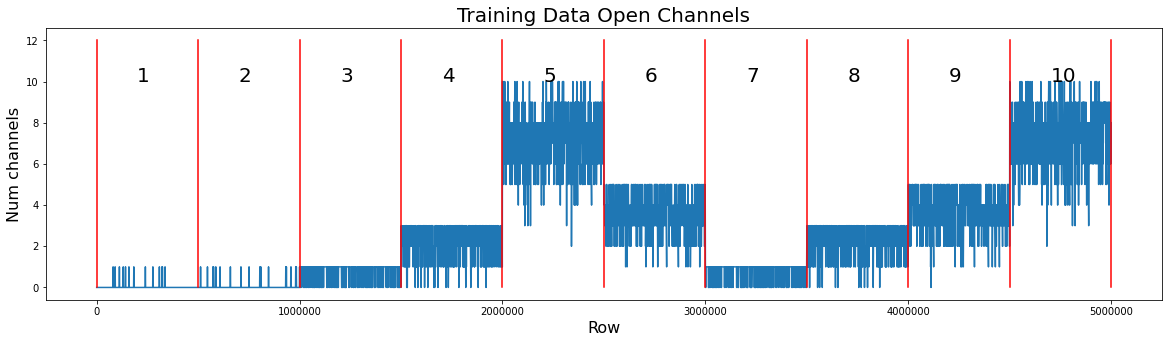

In [35]:
plt.figure(figsize=(20, 5))
res = 1000

# визуализируем каждый 500й сигнал
plt.plot(range(0, train_data.shape[0], res), train_data['open_channels'][0::res])

# построим разделяющие ряды прямые
for i in range(11):
    plt.plot([i*500000,i*500000],[0,12],'r')

# подпишем номер временного ряда
for j in range(10):
    plt.text(j*500000+200000, 10, str(j+1), size=20)

plt.xlabel('Row',size=16)
plt.ylabel('Num channels',size=16); 
plt.title('Training Data Open Channels',size=20)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000, 5000000],
           ['0', '1000000', '2000000', '3000000', '4000000', '5000000'])
plt.show()

В [статье](https://www.nature.com/articles/s42003-019-0729-3) авторы указывают, что добавили синтетический сдвиг к данным (его мы можем видеть как линейное возрастание, или же параболическую форму графика `signal`.  
Убрав сдвиг, мы сможем сделать данные более чистыми и однородными, а значит и улучшить результаты моделей.



> Далее предобработка данных основана на [данном ноутбуке](https://www.kaggle.com/friedchips/clean-removal-of-data-drift)



In [0]:
# разделим данные по графику, при этом 1й временной ряд делим на две части
# из-за того, что к нему частично применен сдвиг
train_segm_separators = np.concatenate([[0,500000,600000], np.arange(1000000,5000000+1,500000)])

# визуально определили группы каждого из временных рядов (11, т.к. 1й поделили на две)
train_segm_signal_groups = [0, 0, 0, 1, 2, 4, 3, 1, 2, 3,4]
# определили отсутствие сдвигов
train_segm_is_shifted = [False, True, False, False, False, False, False, True, True, True, True]

# разделили исходные данные на сегменты
train_signal = np.split(train_data['signal'].values, train_segm_separators[1:-1])
train_opench = np.split(train_data['open_channels'].values, train_segm_separators[1:-1])

Заметим, что данные со сдвигом (параболической формы или линейных) похожи на данные без сдвига, эта похожесть занесена в разделение по группам в ячейке выше.  
Тем самым сегменты 0, 3, 4, 5, 6 являются идеальными представителями своей группы

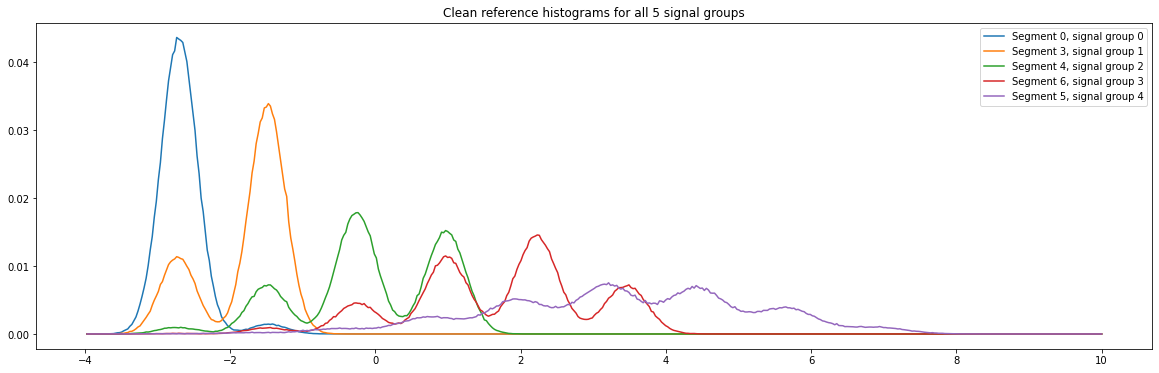

In [37]:
#строим гистограммы значений signal (гладкость за счет plot)

plt.figure(figsize=(20, 6))
clean_hist = []
hist_bins = np.linspace(-4,10,500)

# цикл по каждому из образцов
for j, i in enumerate([0,3,4,6,5]):

    clean_hist.append(np.histogram(train_signal[i], bins=hist_bins)[0])
    clean_hist[-1] = clean_hist[-1] / 500000
    plt.plot(hist_bins[1:], clean_hist[-1], label='Segment '+str(i)+', signal group '+str(j))

plt.legend();
plt.title("Clean reference histograms for all 5 signal groups");

Сравним гистограмму примера 0го класса с гистограммой линейного сдвига (1 сегмента)

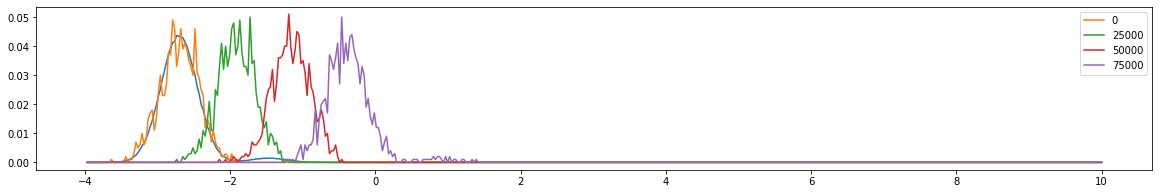

In [38]:
window_size = 1000

plt.figure(figsize=(20, 3))
plt.plot(hist_bins[1:], clean_hist[0]);
for i in [0,25000,50000,75000]:
    window_hist = np.histogram(train_signal[1][i:i+window_size], bins=hist_bins)[0] / window_size
    plt.plot(hist_bins[1:], window_hist, label='{}'.format(i))

plt.legend()
plt.show()

На графиках видно, что распределения действительно почти совпадают, только сдвигаются примерно на +1 в 25 тысяч.  
Нам нужно избавиться от тренда в данных, займемся этим

In [0]:
window_size = 1000 # размер окна, в котором смотрим временные промежутки
bin_width = np.diff(hist_bins)[0] 
s_window = 10 # maximum absolute change in shift from window to window+1
train_signal_shift = []

for clean_id in range(len(train_segm_signal_groups)):
    group_id = train_segm_signal_groups[clean_id]
    window_shift = [] 
    prev_s = 0 # предыдущий сдвиг, сначала сдвига нет
    window_data = train_signal[clean_id].reshape(-1,window_size)

    # для каждого блока в 1000 элементов считаем сдвиг
    for w in window_data:

        # гистограмма для данного блока w #(499, )
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size

        # считаем, что clean_hist[id] задает истинное распределение
        # тогда выражение снизу - кросс-кореляция (можно считать обобщением сдвигов на верхней гистограмме)
        # смотрим в окне длины 2 * window_size от предыдущего сдвига, чтобы
        # не учитывать случайные пики
        window_corr = np.array([np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s - s_window, prev_s + s_window + 1) ])
        # выразили на самом деле оптимальный сдвиг
        prev_s = prev_s - s_window + np.argmax(window_corr)
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    train_signal_shift.append(window_shift)    

Выделяем тренд и убираем его из данных

In [0]:
train_signal_shift_clean = []
train_signal_detrend = []

for data, use_fit, signal in zip(train_signal_shift, train_segm_is_shifted, train_signal):
    # если данные с трендом, то уберем его
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size / 2
        # обучили многочлен 4й степени, который наилучшим образом приближает data по MSE
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([c * data_x ** i for i, c in enumerate(fit)], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    train_signal_shift_clean.append(data_2)
    train_signal_detrend.append(signal + data_2)

Посмотрим на test и проделаем с ним те же самые манипуляции.

In [41]:
test_data = pd.read_csv('test.csv')
print(len(test_data))
test_data.head(5)

2000000


,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


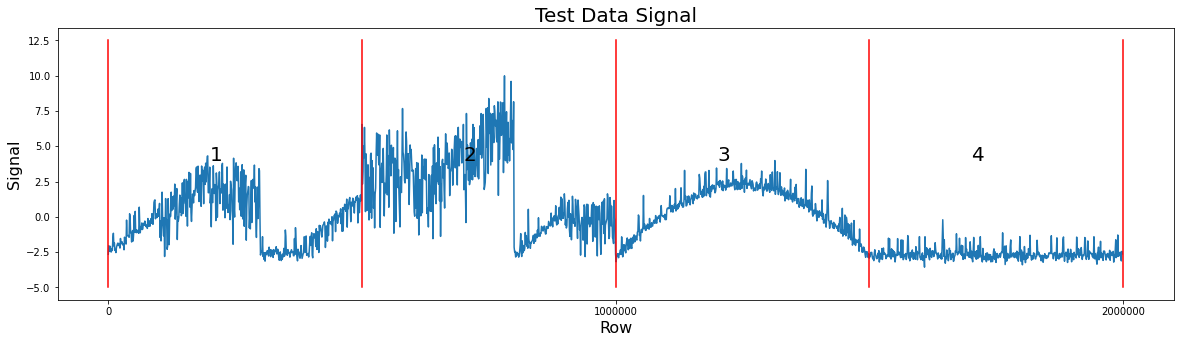

In [42]:
plt.figure(figsize=(20, 5))
res = 1000

# визуализируем каждый 500й сигнал
plt.plot(range(0, test_data.shape[0], res), test_data['signal'][0::res])

# построим разделяющие ряды прямые
for i in range(5):
    plt.plot([i * 500000,i * 500000], [-5, 12.5],'r')

# подпишем номер временного ряда
for j in range(4):
    plt.text(j*500000+200000, 4, str(j+1), size=20)

plt.xlabel('Row',size=16)
plt.ylabel('Signal',size=16); 
plt.title('Test Data Signal',size=20)
plt.xticks([0, 1000000, 2000000],
           ['0', '1000000', '2000000'])
plt.show()

In [0]:
test_segm_separators = np.concatenate([np.arange(0,1000000+1,100000), [1500000,2000000]])
test_segm_signal_groups = [0,2,3,0,1,4,3,4,0,2,0,0]
test_segm_is_shifted = [True, True, False, False, True, False, True, True, True, False, True, False]
test_signal = np.split(test_data['signal'].values, test_segm_separators[1:-1])

In [0]:
window_size = 1000
bin_width = np.diff(hist_bins)[0]
s_window = 10
test_signal_detrend = []
test_signal_shift = []

for clean_id in range(len(test_segm_signal_groups)):
    
    group_id = test_segm_signal_groups[clean_id]
    window_shift = []
    prev_s = 0
    window_data = test_signal[clean_id].reshape(-1,window_size)
    
    for w in window_data:
        window_hist = np.histogram(w, bins=hist_bins)[0] / window_size
        window_corr = np.array([ np.sum(clean_hist[group_id] * np.roll(window_hist, -s)) for s in range(prev_s-s_window, prev_s+s_window+1) ])
        prev_s = prev_s + np.argmax(window_corr) - s_window
        window_shift.append(-prev_s * bin_width)

    window_shift = np.array(window_shift)
    test_signal_shift.append(window_shift)    


In [0]:
test_signal_shift_clean = []
test_signal_detrend = []
test_remove_shift = [True, True, False, False, True, False, True, True, True, False, True, False]

for data, use_fit, signal in zip(test_signal_shift, test_segm_is_shifted, test_signal):
    if use_fit:
        data_x = np.arange(len(data), dtype=float) * window_size + window_size/2
        fit = np.flip(np.polyfit(data_x, data, 4))
        data_x = np.arange(len(data) * window_size, dtype=float)
        data_2 = np.sum([ c * data_x ** i for i, c in enumerate(fit) ], axis=0)
    else:
        data_2 = np.zeros(len(data) * window_size, dtype=float)
        
    test_signal_shift_clean.append(data_2)
    test_signal_detrend.append(signal + data_2)

Визуализируем получшившиеся `train` и `test`

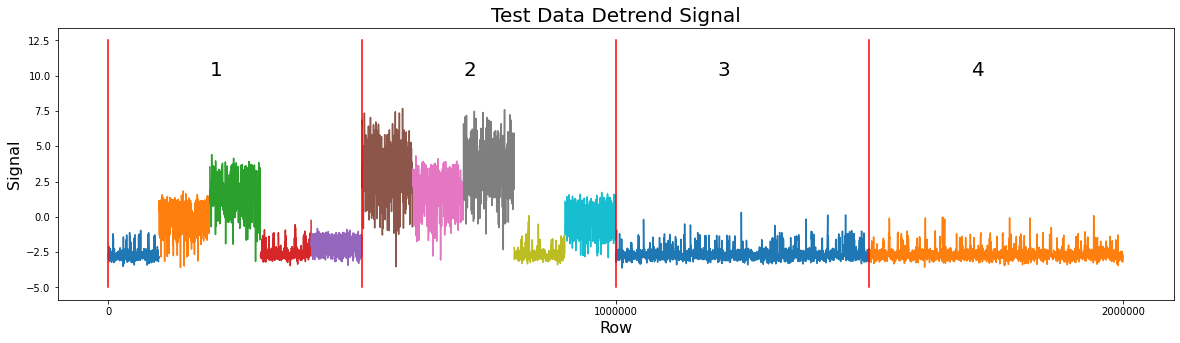

In [58]:
plt.figure(figsize=(20, 5))
res = 250

for i in range(len(test_signal_detrend)):
    plt.plot(np.arange(test_segm_separators[i], test_segm_separators[i + 1], res),
             test_signal_detrend[i][::res])
    
for i in range(4):
    plt.plot([i * 500000, i * 500000], [-5, 12.5],'r')

# подпишем номер временного ряда
for j in range(4):
    plt.text(j*500000+200000, 10, str(j+1), size=20)

plt.xlabel('Row',size=16)
plt.ylabel('Signal',size=16); 
plt.title('Test Data Detrend Signal',size=20)
plt.xticks([0, 1000000, 2000000],
           ['0', '1000000', '2000000'])
plt.show()

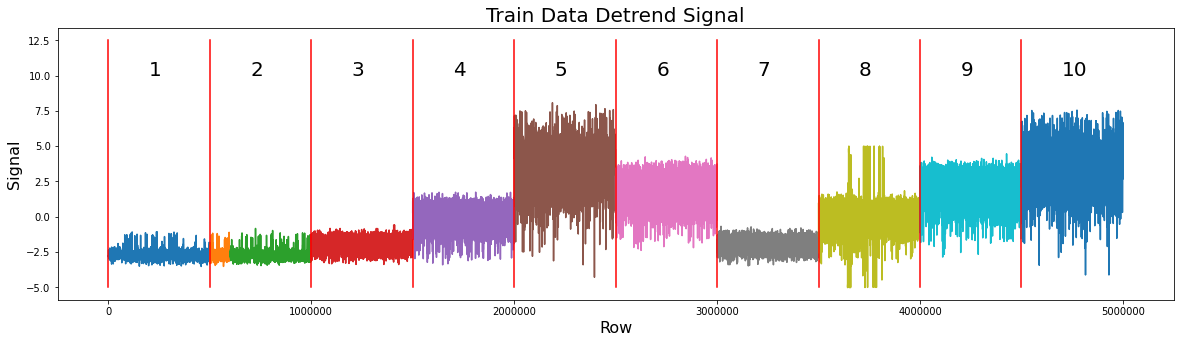

In [59]:
plt.figure(figsize=(20, 5))
res = 250

for i in range(len(train_signal_detrend)):
    plt.plot(np.arange(train_segm_separators[i], train_segm_separators[i + 1], res),
             train_signal_detrend[i][::res])
    
for i in range(10):
    plt.plot([i * 500000, i * 500000], [-5, 12.5],'r')

# подпишем номер временного ряда
for j in range(10):
    plt.text(j*500000+200000, 10, str(j+1), size=20)

plt.xlabel('Row',size=16)
plt.ylabel('Signal',size=16); 
plt.title('Train Data Detrend Signal',size=20)
plt.xticks([0, 1000000, 2000000, 3000000, 4000000, 5000000],
           ['0', '1000000', '2000000', '3000000', '4000000', '5000000'])
plt.show()

Таким образом, нам действительно удалось снять тренд и на тесте, и на трейне.  

### Отчет.  
С исходными данными было произведено преобразование, убирающее тренд.  
С очищенными данными уже можно начинать строить модели, обучать их можно по-разному:
- обучить одну модель на всех данных
- обучить несколько моделей в зависимости от класса, к которому принадлежат данные.  

Второй вариант интуитивно располагает к лучшему скору, его и постараюсь применить, но уже на следующей неделе. В частности, надеюсь реализовать либо упрощенную рекуррентную нейронную сеть, либо WaveNet, которая часто упоминается в публичных kernel-ах.